# TBM notebook

### Import Libraries

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils import *

### Select Transform

In [14]:
transform = 'CLOT' # 'RCDT','CLOT','PLOT'
## TO DO: integrate PLOT

### Select Regression Model

In [23]:
model = 'PLDA' # 'PCA','PLDA','NS','CCA'

### Load Data

In [16]:
# dataset = 'synthetic_2D'
dataset = 'cell_data'

train_dir = '../data/'+dataset+'/training/'
(x_train, y_train) = load_image_data(train_dir)
test_dir = '../data/'+dataset+'/testing/'
(x_test, y_test) = load_image_data(test_dir)

### 1. Apply Transform

In [17]:
template = np.ones(x_train[0].shape, dtype=x_train.dtype)
if transform == 'RCDT':
    from TBM_RCDT import batch_RCDT
    
    thetas = np.linspace(0,180,180)
    batch_rcdt = batch_RCDT(thetas,rm_edge=False)

    x_train_hat = batch_rcdt.forward(x_train, template)
    x_test_hat = batch_rcdt.forward(x_test, template)
elif transform == 'CLOT':
    # Generate reference image by taking mean of RCDT
    from TBM_RCDT import batch_RCDT
    from support.optrans.utils import signal_to_pdf

    thetas = np.linspace(0,180,180)
    batch_rcdt = batch_RCDT(thetas,rm_edge=False)
    x_train_hat = batch_rcdt.forward(x_train, template)
    xhat_mean = np.mean(x_train_hat,axis=0)
    x0 = np.abs(batch_rcdt.inverse(xhat_mean, template))
    img0 = signal_to_pdf(x0, sigma=1., epsilon=8., total=100.)

    # Calculate VOT
    from TBM_CLOT import batch_VOT

    lr=1e-4 
    alpha=0. 
    max_iter=100
    batch_vot = batch_VOT(lr, alpha, max_iter)
    x_train_hat = batch_vot.forward_seq(x_train, img0)
    x_test_hat = batch_vot.forward_seq(x_test, img0)

### 2. Regression Model

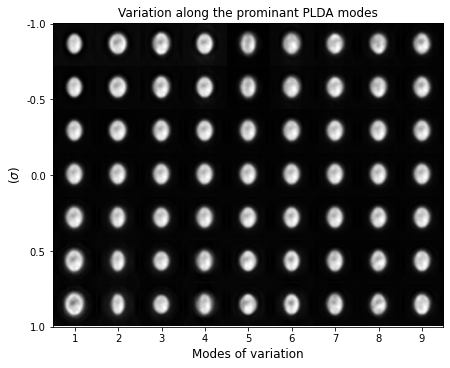

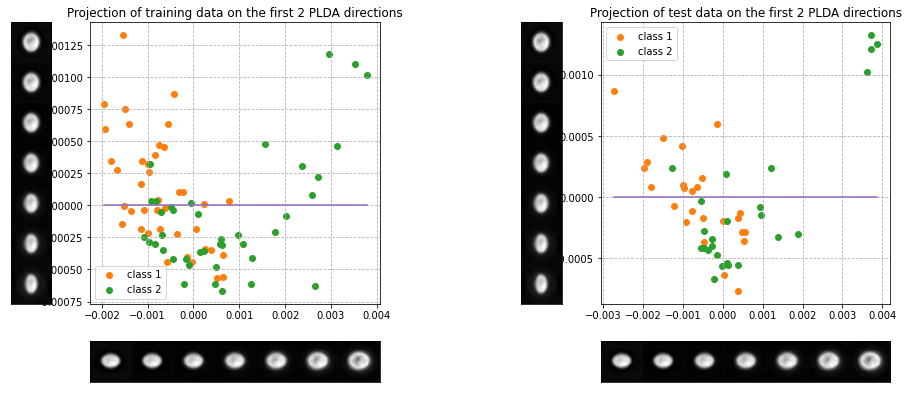

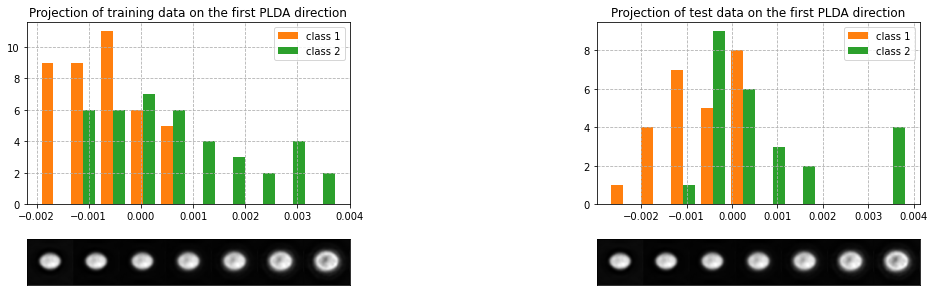

In [24]:
if model == 'PCA':
    if transform == 'RCDT':
        from TBM_RCDT import RCDT_PCA
        n_components = 12
        rcdt_pca = RCDT_PCA(n_components)
        b_hat, p_tr, p_te = rcdt_pca.rcdt_pca(x_train_hat, y_train, x_test_hat, y_test, template)
        rcdt_pca.visualize(directions=9, points=7, thetas=thetas)
    elif transform == 'CLOT':
        from TBM_CLOT import VOT_PCA
        n_components = 12
        clot_pca = VOT_PCA(n_components,lr, alpha, max_iter)
        b_hat, p_tr, p_te = clot_pca.vot_pca(x_train_hat, y_train, x_test_hat, y_test, img0)
        clot_pca.visualize(directions=9, points=7)
elif model == 'PLDA':
    if transform == 'RCDT':
        from TBM_RCDT import RCDT_PLDA
        n_components = 12
        rcdt_plda = RCDT_PLDA(n_components)
        b_hat, p_tr, p_te = rcdt_plda.rcdt_plda(x_train_hat, y_train, x_test_hat, y_test, template)
        rcdt_plda.visualize(directions=9, points=7, thetas=thetas)
    elif transform == 'CLOT':
        from TBM_CLOT import VOT_PLDA
        n_components = 12
        clot_plda = VOT_PLDA(n_components,lr, alpha, max_iter)
        b_hat, p_tr, p_te = clot_plda.vot_plda(x_train_hat, y_train, x_test_hat, y_test, img0)
        clot_plda.visualize(directions=9, points=7)
elif model == 'CCA':
    if transform == 'RCDT':
        from TBM_RCDT import RCDT_CCA
        n_components = 9
        rcdt_cca = RCDT_CCA(n_components)
        b_hat1,bhat2,p_tr1,p_tr2,p_te1,p_te2 = rcdt_cca.rcdt_cca(x_train_hat, y_train, x_test_hat, y_test, template)
        rcdt_cca.visualize(directions=5, points=7, thetas=thetas)
    elif transform == 'CLOT':
        from TBM_CLOT import VOT_CCA
        n_components = 9
        clot_cca = VOT_CCA(n_components,lr, alpha, max_iter)
        b_hat1,bhat2,p_tr1,p_tr2,p_te1,p_te2 = clot_cca.vot_cca(x_train_hat, y_train, x_test_hat, y_test, img0)
        clot_cca.visualize(directions=7, points=7)
elif model == 'NS':
    if transform == 'RCDT':
        from TBM_RCDT import RCDT_NS_Classifier
        rcdt_ns = RCDT_NS_Classifier(train_sample=32, use_gpu=False)
        y_predicted = rcdt_ns.classify_RCDT_NS(x_train_hat, y_train, x_test_hat, y_test)
    elif transform == 'CLOT':
        from TBM_CLOT import VOT_NS_Classifier
        clot_ns = VOT_NS_Classifier(train_sample=32, use_gpu=False)
        y_predicted = clot_ns.classify_VOT_NS(x_train_hat, y_train, x_test_hat, y_test)